The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0.0001, 1], [0.0001, 1], [1, 10000], [0.001, 10000], [1, 100000], [1, 10000], [0.86, 0.91]]


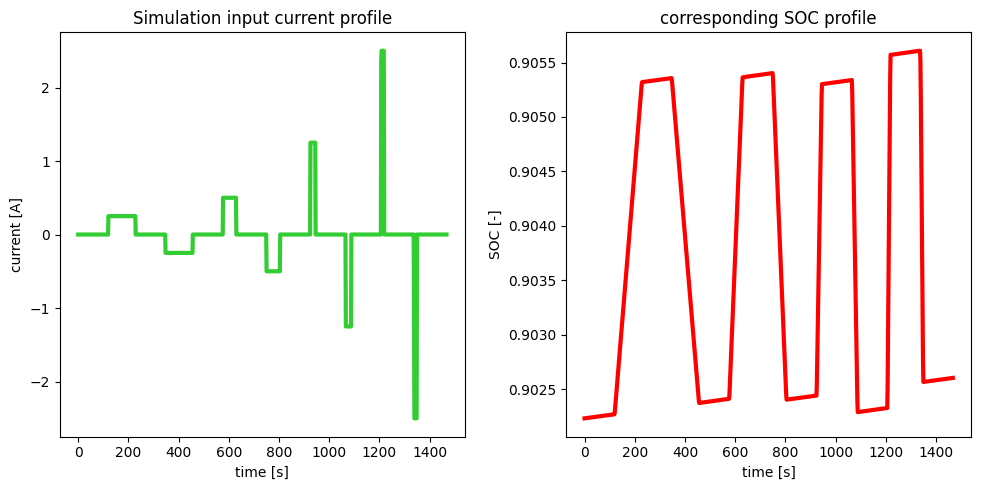

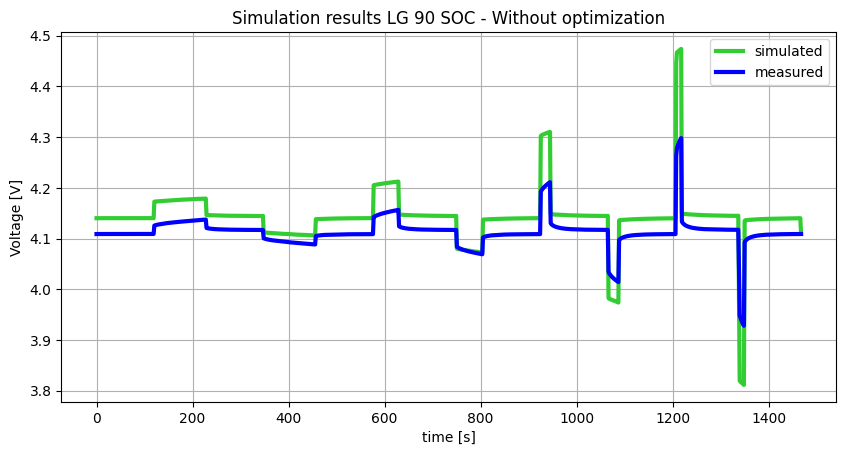

In [10]:
import numpy as np
from scipy import interpolate, integrate, optimize
import matplotlib.pyplot as plt
import Battery_model

import Misc
%load_ext autoreload
%autoreload 2

#*******************PARAMETERS OF THE SIMULATION****************************
Battery_current = "m"           #Two options: "m" for "measured", "s" for "synthetic"

Hysteresis_enable = "1"         #Two options:   "1" enabled, "0" ECM without Hysteresis
beta_fitting = ["1", 100]     #Two options:   "1" enabled, "0" User defined (enter custom value)                    [Relevant only if Hysteresis_enable == "1"]
U_H0_fitting = ["f", 0.002]     #Three options: "1" enabled, "0" User defined (enter custom value), "f" From file     [Relevant only if Hysteresis_enable == "1"]

Battery_brand = "LG"            #Two options: "LG" for LG, "S" for Samsung
Battery_SOC_measurement = "90"  #Multiple options: "10", "30", "50", "70", "90"

precission = 1000 #Desired temporal precission of the simulation result

Battery_capacity = 2.5 #Ah

#*** BOUNDS DEFINITION ***

#Meje za vsakega od parametrov. Če jih povečamo bo optimizacija trajala dlje. Če jih zmanjšamo tvegamo da zgrešimo pravo rešitev
b_SOC_init = {"Pulzno_10SOC": [0.000,0.205],
              "Pulzno_30SOC": [0.290,0.305],
              "Pulzno_50SOC": [0.480,0.505],
              "Pulzno_70SOC": [0.680,0.705],
              "Pulzno_90SOC": [0.890,0,905],
              "PulseTest_LG02_SOC_10": [0.060,0.110],
              "PulseTest_LG02_SOC_30": [0.260,0.310],
              "PulseTest_LG02_SOC_50": [0.460,0.510],
              "PulseTest_LG02_SOC_70": [0.660,0.710],
              "PulseTest_LG02_SOC_90": [0.860,0.910]}

b_R0 =   [0.0001,1]
b_R1 =   [0.0001,1]
b_C1 =   [1,10000]
b_R2 =   [0.001,10000]
b_C2 =   [1,100000]
b_Beta = [1,10000]      #Relevant only if Hysteresis_enable == "1" and beta_fitting == "1"
b_U_H0 = [0.01,0.1]     #Relevant only if Hysteresis_enable == "1" and U_H0_fitting == "1"

#*** FILE and PATH DEFINITIONS*** (files are added in Misc.py)
folder_name_measurement = "./Testing/"
file_name_measurement = Misc.Battery_select(Battery_brand, "Measurement", Battery_SOC_measurement) #Measurement file

folder_name_OCV = "./OCV/"
file_name_OCV = Misc.Battery_select(Battery_brand, "OCV") #OCV file

if Hysteresis_enable == "1" and U_H0_fitting[0] == "f":
    folder_name_HYS = "./Histereza/"
    file_name_HYS = Misc.Battery_select(Battery_brand, "Hysteresis") #Hysteresis file

#*** DUMMY VALUES (applicable only in first workbook) ***

R0 = 0.120  #Ohm
R1 = 0.01   #Ohm
C1 = 10     #As/V
R2 = 0.01   #Ohm
C2 = 5000   #As/V

#***********  Next lines are only relevant in synthetic Batter_current mode ****************

#initial state of charge - between 0 (empty nattery) and 1 (full battery)
SOC_init = 1

#how many seconds we want to simulate
end_time = 3600

#Synthetic current profile definition
def fun_current(time):
    #User can provide any function of time to be used for the current/time dependency in the model

    #Few pre-prepared options:

    #I_0 = 2.5; return I_0*np.ones(len(time))                       #constant current with value I_0 in Ampers
    #k = (2*(Battery_capacity-SOC_init)/end_time); return k*time   #Linearly increasing current with time koeficient k in Ampers/s
    Omega = 0.01; I_amp = 0.1; return 0.1*np.sin(Omega*time/2*np.pi)                   #sinusoidal current with ferquency Omega in Herzs and apmlitude I_amp in Ampers


#*** OCV TABLE PREPARATION ****

#file name specification
file_OCV = folder_name_OCV + file_name_OCV + ".txt" #.txt file name

#OCV (open circuit voltage) data reading and storing to lists
SOC_OCV_table = np.loadtxt(file_OCV, skiprows = 1)[:,0] #first column of the OCV table represents SOC values
OCV_OCV_table = np.loadtxt(file_OCV, skiprows = 1)[:,1] #secon column of the OCV table represents OCV values

#interpolating imported OCV data
SOC_interp = interpolate.interp1d(OCV_OCV_table, SOC_OCV_table, fill_value='extrapolate')   #SOC(OCV) function - inverse function for SOC_init determination
OCV_interp = interpolate.interp1d(SOC_OCV_table, OCV_OCV_table, fill_value='extrapolate')   #OCV(SOC) function

#*********** Experimental data processing if in "measured" mode ****************
if Battery_current == "m":

    #file name specification of measured dataset
    file_measurement = folder_name_measurement + file_name_measurement + ".txt" #.txt file name

    time_measured = np.loadtxt(file_measurement, skiprows = 1)[:,0]        #import experimental data - time
    time_measured = time_measured - time_measured[0]                            #align starting measurement time to zero

    end_time = time_measured[-1]        #reading end time of the measurement
    delta_t = end_time/precission       #time step of the simulation is determined from measurement duration and specified precission
    time_simulated = np.arange(0,end_time, delta_t)     #simulation time table is generated

    I_B_measured = np.loadtxt(file_measurement, skiprows = 1)[:,1]/1000    #import experimental data - battery current
    U_B_measured = np.loadtxt(file_measurement, skiprows = 1)[:,2]/1000    #import experimental data - battery voltage

    #*** INTERPOLATING ALL IMPORTED DATA ***
    #All importet experimental data need to be interpolated before further use

    I_B_interp = interpolate.interp1d(time_measured, I_B_measured, fill_value='extrapolate')
    U_B_interp = interpolate.interp1d(time_measured, U_B_measured, fill_value='extrapolate')

    #interpolation functions are evaluated at all the simulation times - simulation and measurement points will be aligned
    U_B_measured_for_comparison = U_B_interp(time_simulated)
    I_B_simulated = I_B_interp(time_simulated)


    #determination of initial SOC from first value of voltage in the measurement
    SOC_init = SOC_interp(U_B_measured[0])

    #calculation of SOC/time dependency for the whole simulation - with time integration of applied current we get the current
    SOC_simulated = SOC_init + integrate.cumulative_trapezoid(I_B_simulated, initial=0)*delta_t/(Battery_capacity*3600)

#*********** if "synthetic" mode is chosen, we do not have measurement for comparisson ***********
if Battery_current == "s":

    #simulation time step determination from chosen end time and precision
    delta_t = end_time/precission
    time_simulated = np.arange(0,end_time, delta_t)

    #synthetic current profile is determined for all simulation times with the fuctnion fun_current
    I_B_simulated = fun_current(time_simulated)

    #calculation of SOC/time dependency for the whole simulation - with time integration of applied current we get the current
    SOC_simulated = SOC_init + integrate.cumulative_trapezoid(I_B_simulated, initial=0)*delta_t/(Battery_capacity*3600)

#**** HYS TABLE PREPARATION ****
if Hysteresis_enable == "1":
    if U_H0_fitting[0] == "f":
        #file name specification
        file_HYS = folder_name_HYS + file_name_HYS + ".txt" #.txt file name

        #HYS (hysteresis) data reading and storing to lists
        SOC_HYS_table = np.loadtxt(file_HYS, skiprows = 1)[:,0] #first column of the HYS table represents SOC values
        HYS_HYS_table = np.loadtxt(file_HYS, skiprows = 1)[:,1] #secon column of the HYS table represents HYS values

        HYS_interp = interpolate.interp1d(SOC_HYS_table, HYS_HYS_table, fill_value='extrapolate')   #HYS(SOC) function
        HYS_simulated = HYS_interp(SOC_simulated)
else:
    U_H0_fitting[0] = "0"
    beta_fitting[0] = "0"

bounds = [b_R0, b_R1, b_C1, b_R2, b_C2,
          b_Beta if beta_fitting[0] == "1" else None,
          b_U_H0 if U_H0_fitting[0] == "1" else None,
          b_SOC_init[file_name_measurement]]

bounds = [x for x in bounds if x is not None]

print(bounds)

#********************** Checking the prepared tables of I_B_simulated, SOC_simulated and time_simulated by plotting ***************
# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # figsize controls the size of the figure
# First plot
ax1.plot(time_simulated, I_B_simulated, color="limegreen", linewidth=3)
ax1.set_title("Simulation input current profile")
ax1.set_xlabel('time [s]')
ax1.set_ylabel('current [A]')
# Second plot
ax2.plot(time_simulated, SOC_simulated, color="red", linewidth=3)
ax2.set_title("corresponding SOC profile")
ax2.set_xlabel('time [s]')
ax2.set_ylabel('SOC [-]')
# Adjust layout to avoid overlap
plt.tight_layout()
# Show the plots
plt.show()

#****************** Running simulation - battery model is in separate file Battery_model.py *******************************************************
U_B_simulated = Battery_model.RC_model([R0, R1, C1, R2, C2], time_simulated, delta_t, I_B_simulated, SOC_simulated, OCV_interp, HYS_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting)
#************************************** plotting results of simulation ***********************************************************
plt.figure().set_figwidth(10)
plt.plot(time_simulated, U_B_simulated, color="limegreen", linewidth=3, label="simulated")
if Battery_current == "m": #in "measured" mode comparisson betwenn experimental and simulated data is ploted
    plt.plot(time_simulated, U_B_measured_for_comparison, color="blue", linewidth=3, label="measured")
plt.title("Simulation results" + " " + Battery_brand + " " + Battery_SOC_measurement + " SOC - Without optimization")
plt.xlabel("time [s]")
plt.ylabel("Voltage [V]")
plt.grid(True)
plt.legend()
plt.show()

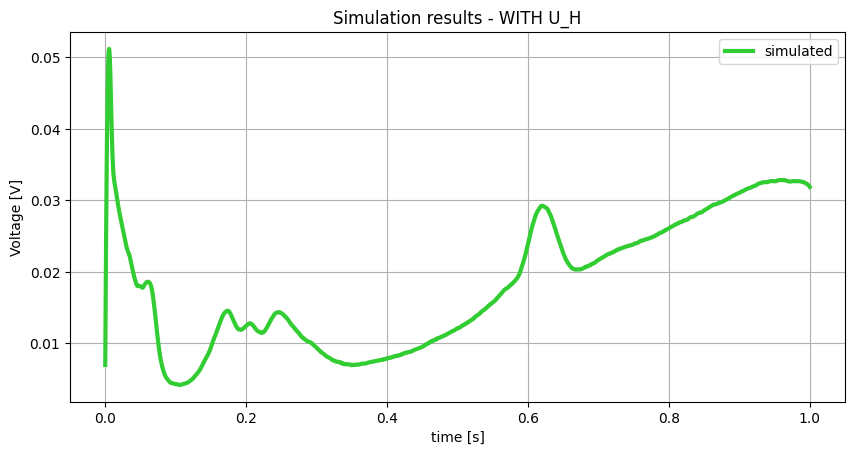

In [11]:
plt.figure().set_figwidth(10)
plt.plot(SOC_HYS_table, HYS_HYS_table, color="limegreen", linewidth=3, label="simulated")
plt.title("Simulation results - WITH U_H")
plt.xlabel("time [s]")
plt.ylabel("Voltage [V]")
plt.grid(True)
plt.legend()
plt.show()

Following routine determines values of parameters R0, R1, C1, R2 and C2 by minimiziation of difference between simulation and experimental result.

IMPORTANT: Make sure the first notebook has been run in "measured" mode for this one to function properly.

In [11]:
#****************** BASIC OPTIMISATION ROUTINE *********************************************************

#RMSD function is used as a cost function for minimization
def RMSD(params):
    #returns average difference between simulated and measured data for given set of parameters (params)

    #RMSD - Root Mean Square Deviation
    return np.sqrt(((Battery_model.RC_model(params, time_simulated, delta_t, I_B_simulated, SOC_simulated, OCV_interp, HYS_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting) - U_B_measured_for_comparison)**2).sum(-1).mean())

#optimisation searches for the parameters inside specified bounds
optimisation_resut = optimize.differential_evolution(RMSD,bounds[:-1],disp=True, tol = 1e-7) #optimiztion (fitting)
opt_params = optimisation_resut.x #storing results of optimisation in list

#Using calculated optimized parameters in battery model to test how good they are
U_B_optimized = Battery_model.RC_model(opt_params, time_simulated, delta_t, I_B_simulated, SOC_simulated, OCV_interp, HYS_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting)

#Plotting results of simulation with optimal parameters
Misc.Plot_compare(U_B_optimized, U_B_measured_for_comparison, time_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting, Battery_brand, Battery_SOC_measurement, "", " [Fitting] ")

#printig calculated optimal parameters
Misc.Print_optimal(opt_params, beta_fitting, U_H0_fitting, "")

differential_evolution step 1: f(x)= 0.9559779383963056
differential_evolution step 2: f(x)= 0.9559779383963056
differential_evolution step 3: f(x)= 0.9538186329171151
differential_evolution step 4: f(x)= 0.9426270557265662
differential_evolution step 5: f(x)= 0.9426270557265662
differential_evolution step 6: f(x)= 0.9426270557265662
differential_evolution step 7: f(x)= 0.9426270557265662
differential_evolution step 8: f(x)= 0.9426270557265662
differential_evolution step 9: f(x)= 0.9418591738778606
differential_evolution step 10: f(x)= 0.9418591738778606
differential_evolution step 11: f(x)= 0.9408353383925351
differential_evolution step 12: f(x)= 0.9408353383925351
differential_evolution step 13: f(x)= 0.9402596331820835
differential_evolution step 14: f(x)= 0.940164672736008
differential_evolution step 15: f(x)= 0.9386688272609813
differential_evolution step 16: f(x)= 0.9161824018395918


KeyboardInterrupt: 

This routine performs the same optimization as the previous one but includes an additional parameter: SOC_init. This is particularly useful when it is unclear whether the battery was in a relaxed state at the beginning of the measurement used for optimization. In addition to optimizing R0, R1, C1, R2, and C2, this routine also adjusts SOC_init.

IMPORTANT: Make sure the first notebook has been run in "measured" mode for this one to function properly.

differential_evolution step 1: f(x)= 0.10152078346397239
differential_evolution step 2: f(x)= 0.10152078346397239
differential_evolution step 3: f(x)= 0.10152078346397239
differential_evolution step 4: f(x)= 0.0913195108526902
differential_evolution step 5: f(x)= 0.0913195108526902
differential_evolution step 6: f(x)= 0.0913195108526902
differential_evolution step 7: f(x)= 0.07614182331853202
differential_evolution step 8: f(x)= 0.07614182331853202
differential_evolution step 9: f(x)= 0.07112199469537829
differential_evolution step 10: f(x)= 0.03250153899462698
differential_evolution step 11: f(x)= 0.03250153899462698
differential_evolution step 12: f(x)= 0.03250153899462698
differential_evolution step 13: f(x)= 0.03250153899462698
differential_evolution step 14: f(x)= 0.03250153899462698
differential_evolution step 15: f(x)= 0.03250153899462698
differential_evolution step 16: f(x)= 0.03250153899462698
differential_evolution step 17: f(x)= 0.03250153899462698
differential_evolution ste

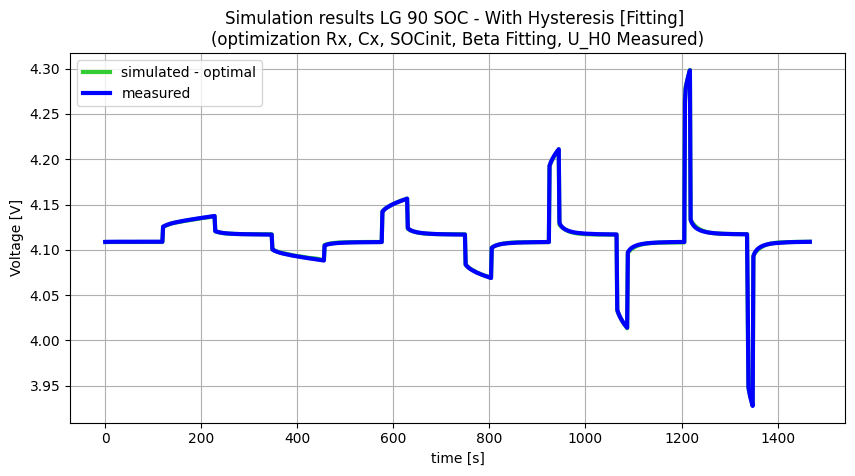

 Optimal R0 = 0.06578757110808224
 Optimal R1 = 0.013887804688486742
 Optimal C1 = 1210.4664851370017
 Optimal R2 = 0.7177585321653775
 Optimal C2 = 5863.212839388601
 Optimal beta = 1.3219630267233382
 Optimal SOC_init = 0.8761474781780495


In [24]:
#******************* INCLUDING SOCinit OPTIMISATION ROUTINE *********************************************************

#RMSD function is used as a cost function for minimization
def RMSD(params):
    soc_init  = params[-1]
    soc_simulated = soc_init + integrate.cumulative_trapezoid(I_B_simulated, initial=0)*delta_t/(Battery_capacity*3600)

    #RMSD - Root Mean Square Deviation
    return np.sqrt(((Battery_model.RC_model(params[:-1], time_simulated, delta_t, I_B_simulated, soc_simulated, OCV_interp, HYS_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting) - U_B_measured_for_comparison)**2).sum(-1).mean())

optimisation_resut = optimize.differential_evolution(RMSD,bounds,disp=True, tol = 1e-7) #optimizacija (fitting)
opt_params = optimisation_resut.x

#problem, ker je bil definiran opt_params[5]
SOC_simulated = opt_params[-1] + integrate.cumulative_trapezoid(I_B_simulated, initial=0)*delta_t/(Battery_capacity*3600)
U_B_optimized = Battery_model.RC_model(opt_params[:-1], time_simulated, delta_t, I_B_simulated, SOC_simulated, OCV_interp, HYS_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting)

#Plotting results of simulation with optimal parameters
Misc.Plot_compare(U_B_optimized, U_B_measured_for_comparison, time_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting, Battery_brand, Battery_SOC_measurement, ", SOCinit", " [Fitting] ")

#printig calculated optimal parameters
Misc.Print_optimal(opt_params, beta_fitting, U_H0_fitting, "")


This routine performs the same optimization as the previous one but utilizes the amoeba (Nelder-Mead) optimization algorithm instead of differential evolution. 

IMPORTANT: Ensure all previous notebooks have been run for this one to function properly.

Best RMSD amoeba =  0.014294613560188402


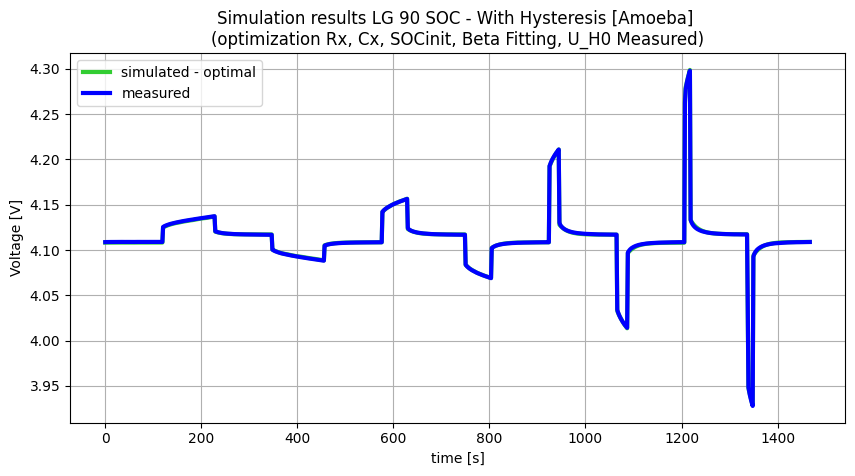

Amoeba Optimal R0 = 0.03452080544495339
Amoeba Optimal R1 = 0.013775157980151144
Amoeba Optimal C1 = 1193.4292356746555
Amoeba Optimal R2 = 1.5859566792315443
Amoeba Optimal C2 = 5555.159073947723
Amoeba Optimal beta = 1835.4827025432562
Amoeba Optimal SOC_init = 0.9016620908702642


In [46]:
#******************* AMOEBA OPTIMISATION ROUTINE *********************************************************

#RMSD function is used as a cost function for minimization
def RMSD(params):

    soc_simulated = params[-1] + integrate.cumulative_trapezoid(I_B_simulated, initial=0)*delta_t/(Battery_capacity*3600)
    return np.sqrt(((Battery_model.RC_model(params[:-1], time_simulated, delta_t, I_B_simulated, soc_simulated, OCV_interp, HYS_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting) - U_B_measured_for_comparison)**2).sum(-1).mean())

initial_guess = opt_params
optimisation_resut = optimize.minimize(RMSD,initial_guess, method="Nelder-Mead", tol = 1e-7) #optimizacija (fitting)
amoeba_params = optimisation_resut.x

print("Best RMSD amoeba = ", RMSD(amoeba_params))

SOC_simulated = amoeba_params[-1] + integrate.cumulative_trapezoid(I_B_simulated, initial=0)*delta_t/(Battery_capacity*3600)
U_B_optimized = Battery_model.RC_model(amoeba_params[:-1], time_simulated, delta_t, I_B_simulated, SOC_simulated, OCV_interp, HYS_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting)

#Plotting results of simulation with optimal parameters
Misc.Plot_compare(U_B_optimized, U_B_measured_for_comparison, time_simulated, Hysteresis_enable, beta_fitting, U_H0_fitting, Battery_brand, Battery_SOC_measurement, ", SOCinit", " [Amoeba] ")

#printig calculated optimal Amoeba parameters
Misc.Print_optimal(amoeba_params, beta_fitting, U_H0_fitting, "Amoeba")